In [2]:
import os
import torch
import wfdb
import numpy as np
import neurokit2 as nk
from tqdm import tqdm

train = [101, 106, 108, 109, 112, 114, 115, 116, 118, 119, 122, 124, 201, 203, 205, 207, 208, 209, 215, 220, 223, 230]
test = [100, 103, 105, 111, 113, 117, 121, 123, 200, 202, 210, 212, 213, 214, 219, 221, 222, 228, 231, 232, 233, 234]
val = [102, 104, 107, 217]
all = train + test
data_folder = '/media/Volume/data/MIT-BHI/data/raw'

In [3]:
signals_train = []
for i in tqdm(train):
    signal, _ = wfdb.rdsamp(os.path.join(data_folder, f'{i}'))
    signals_train.append(signal)

signals_test = []
for i in tqdm(test):
    signal, _ = wfdb.rdsamp(os.path.join(data_folder, f'{i}'))
    signals_test.append(signal)

signals_val = []
for i in tqdm(val):
    signal, _ = wfdb.rdsamp(os.path.join(data_folder, f'{i}'))
    signals_val.append(signal)

print('Signals loaded')

annotations_train = []
for i in tqdm(train):
    annotation = wfdb.rdann(os.path.join(data_folder, f'{i}'), 'atr')
    annotations_train.append((i, annotation))

annotations_test = []
for i in tqdm(test):
    annotation = wfdb.rdann(os.path.join(data_folder, f'{i}'), 'atr')
    annotations_test.append((i, annotation))

annotations_val = []
for i in tqdm(val):
    annotation = wfdb.rdann(os.path.join(data_folder, f'{i}'), 'atr')
    annotations_val.append((i, annotation))

print('Annotations loaded')

100%|██████████| 4/4 [00:00<00:00, 57.00it/s]


Signals loaded


100%|██████████| 4/4 [00:00<00:00, 222.59it/s]

Annotations loaded


0it [00:00, ?it/s]

Count of NaN elements in t_offsets: 126
Len of t and r peaks should be the same:  2027 2027
 first r_peak and then t_offset:  351 479


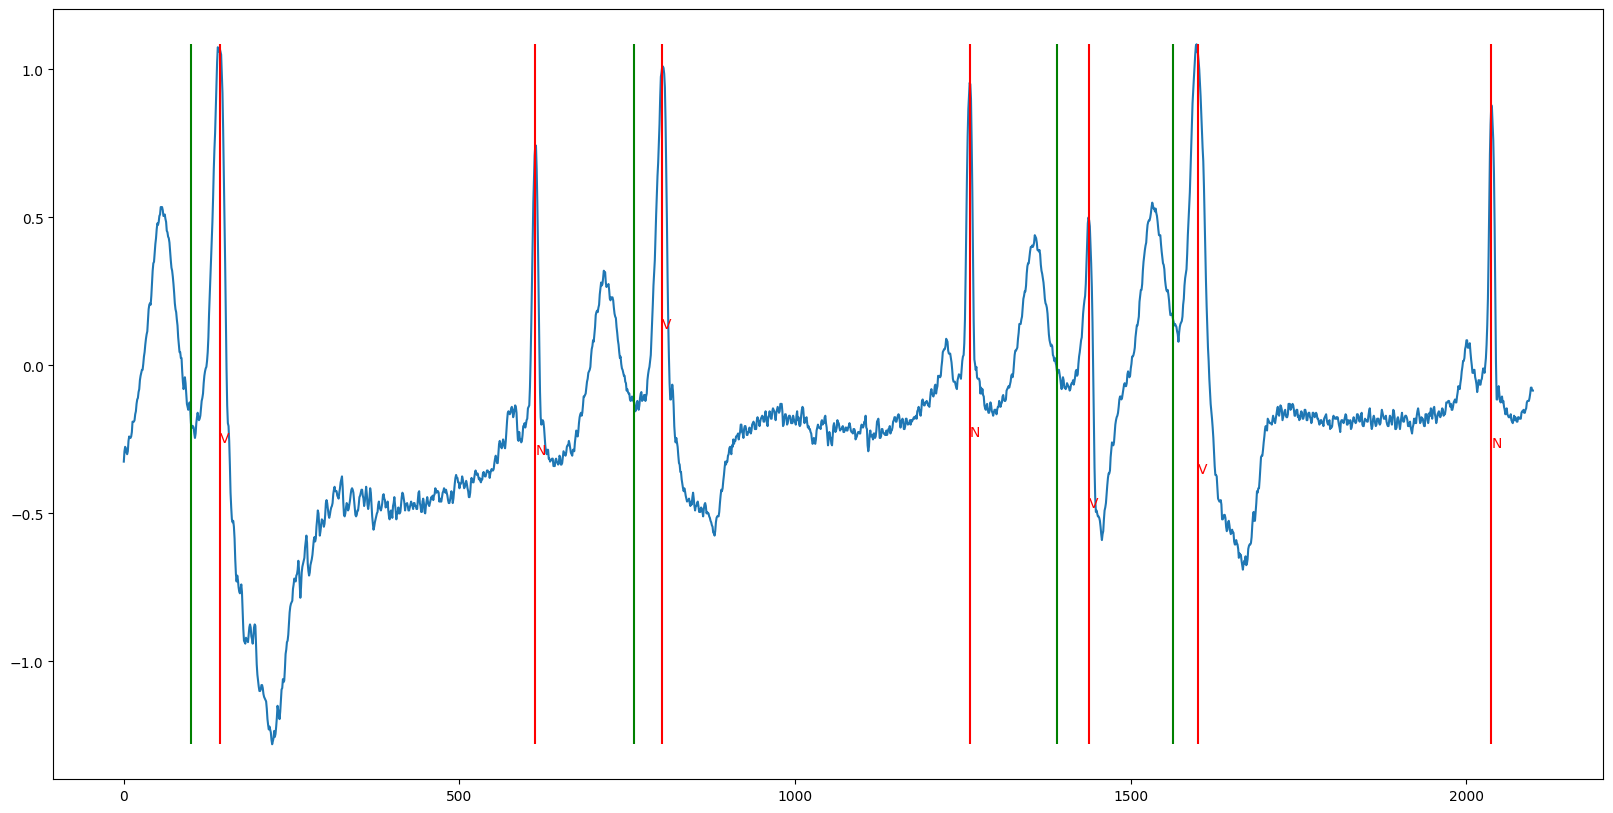

1it [00:03,  3.99s/it]


In [ ]:
from collections import Counter
from matplotlib import pyplot as plt
import pandas as pd
import shutil


# for each patient, divide the signal every half peaks
def convert_label(symbol):
    if symbol in ['N', 'L', 'R', 'e', 'j']: 
        return 'N'
    elif symbol in ['A', 'a', 'J', 'S']:
        return 'S'  # Supraventricular ectopic
    elif symbol in ['V', 'E']: 
        return 'V'  # Ventricular ectopic
    elif symbol in ['F']: 
       return 'F'  # Fusion
    elif symbol in ['/', 'f', 'Q']:
        return 'Q'  # Unknown
    else:
        print(symbol)
        raise(f'Unknown symbol {symbol}') 
    
def crete_csv_mapping(patient_ids, data_folder, split='train', hb_split_type='t_wave', name='t_wave_split'):
    # remove the folder if it exists and create a new one
    if os.path.exists(data_folder + name):
        shutil.rmtree(data_folder + name)
        os.makedirs(data_folder + name, exist_ok=True)

    for patient in tqdm(patient_ids):
        signal, _ = wfdb.rdsamp(os.path.join(data_folder, f'{patient}'))
        signal = signal[:, 0] # consider only one channel
        annotation = wfdb.rdann(os.path.join(data_folder, f'{patient}'), 'atr')

        r_peaks = annotation.sample
        labels = annotation.symbol

        valid_annotations = ['N', 'L', 'R', 'e', 'j', 'A', 'a', 'J', 'S', 'V', 'E', 'F', '/', 'f', 'Q']

        # filter out the annotations that are not in the valid_annotations
        r_peaks = [r_peak for i, r_peak in enumerate(r_peaks) if labels[i] in valid_annotations]
        labels = [label for label in labels if label in valid_annotations]

        # find the T waves offsets
        if hb_split_type == 't_wave':
            cleaned_signal = nk.ecg_clean(signal, sampling_rate=360)
            _, waves_peak = nk.ecg_delineate(
                cleaned_signal, 
                rpeaks=r_peaks, 
                method='dwt',
                sampling_rate=360,
                show=False,
            )
            
            t_offsets = waves_peak['ECG_T_Offsets']
            # if any of this has a nan value print
            print('Count of NaN elements in t_offsets:', np.isnan(t_offsets).sum())

        with open(os.path.join(data_folder + name, 'labels.csv'), 'a') as f:
            f.write(f'patient,sample_id,orig_label,label,start,end\n')

            start = 0
            end = 0
            for i, r_p, t_o in enumerate(zip(r_peaks, t_offsets)):
                prev_end = end
                if np.isnan(t_o):
                    # if this is the last element
                    if i == len(r_peaks) - 1:
                        end = len(signal)
                    else:
                        end = (r_p + r_peaks[i + 1]) // 2
                else:
                    end = t_o

                start = prev_end

                f.write(f'{patient},{i},{labels[i]},{convert_label(labels[i])},{start},{end}\n')
            

            

        print('Len of t and r peaks should be the same: ', len(t_offsets), len(r_peaks))
        print(' first r_peak and then t_offset: ', r_peaks[0], t_offsets[0])

        # plot the signal part where nan values are present, interval start is the index of the first nan value
        interval_start_idx = np.where(np.isnan(t_offsets))[0][10]
        interval_start = t_offsets[interval_start_idx - 1] - 100
        interval_end = t_offsets[interval_start_idx - 1] + 2000

        plt.figure(figsize=(20, 10))
        plt.plot(signal[interval_start:interval_end])
        # add the t peaks adding a vertical line
        for t_peak in t_offsets:
            if interval_start < t_peak < interval_end:
                plt.vlines(t_peak - interval_start, ymin=signal[interval_start:interval_end].min(), ymax=signal[interval_start:interval_end].max(), color='g')
        for i, r_peak in enumerate(r_peaks):
            if interval_start < r_peak < interval_end:
                plt.vlines(r_peak - interval_start, ymin=signal[interval_start:interval_end].min(), ymax=signal[interval_start:interval_end].max(), color='r')
                plt.text(r_peak - interval_start, signal[r_peak - interval_start], labels[i], color='r')

        plt.show()

        break

crete_csv_mapping(train, data_folder, split='train', hb_split_type='t_wave')

In [ ]:
from neurokit2 import ecg_clean
from old.ecg_preprocessing import *
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.combine import SMOTETomek
import shutil
from collections import Counter

valid_annotations = ['N', 'L', 'R', 'e', 'j', 'A', 'a', 'J', 'S', 'V', 'E', 'F', '/', 'f', 'Q']

def convert_original_label(symbol):
    # get the index of the symbol in the valid annotations
    try:
        return valid_annotations.index(symbol)
    except:
        print(symbol)
        raise(f'Unknown symbol {symbol}')

# for each patient, divide the signal every half peaks
def convert_label(symbol):
    if symbol in ['N', 'L', 'R', 'e', 'j']: 
        return 'N'
    elif symbol in ['A', 'a', 'J', 'S']:
        return 'S'  # Supraventricular ectopic
    elif symbol in ['V', 'E']: 
        return 'V'  # Ventricular ectopic
    elif symbol in ['F']: 
       return 'F'  # Fusion
    elif symbol in ['/', 'f', 'Q']:
        return 'Q'  # Unknown
    else:
        print(symbol)
        raise(f'Unknown symbol {symbol}') 

def normalize(signal, method='normal'):
    if method == '01':
        return signal / np.abs(signal).max()
    elif method == 'normal':
        return (signal - signal.mean(axis=0)) / signal.std(axis=0)
    else:
        return signal
    
def preprocess(signal, method='nk_clean'):
    if method == 'nk_clean':
        signal[:, 0] = ecg_clean(signal[:, 0], sampling_rate=360)
        signal[:, 1] = ecg_clean(signal[:, 1], sampling_rate=360)
        return signal
    elif method == 'bas_wander':
        signal[:, 0] -= baseline_als(signal[:, 0], lam=1e7, p=0.3, niter=5)
        signal[:, 1] -= baseline_als(signal[:, 1], lam=1e7, p=0.3, niter=5)
        return signal
    else:
        return signal
    

def create_samples(
        signals, 
        annotations, 
        data_folder='data/preprocessed_base/', 
        subset='train', 
        in_memory=False, 
        preprocessing_method=None, 
        normalization='normal', 
        splitting_method='mid_peak',
        use_smote=False,
    ):
    """
    Create samples from the signals and annotations

    Args:
    - signals: list of numpy arrays with the signals
    - annotations: list of wfdb annotations
    - data_folder: folder to save the samples
    - subset: subset name (train, test, val)
    - in_memory: if True, return the samples in memory without saving to disk
    - preprocessing_method: method to preprocess the signal (None, 'nk_clean', 'bas_wander')
    - normalization: normalization method ('normal', '01')
    - classes: list of classes to consider (default ['N', 'S', 'V', 'F', 'Q'])
    """

    # percentage margin allowd between the peaks
    margin_perc = 0.3
    if not in_memory:
        if os.path.exists(data_folder + subset):
            shutil.rmtree(data_folder + subset)
        os.makedirs(data_folder + subset, exist_ok=True)
    processed_samples = []
    for i, (signal, annotation) in tqdm(enumerate(zip(signals, annotations))):
        user_id, ann = annotation
        peaks_orig = ann.sample
        labels_orig = ann.symbol
        #print(labels_orig)

        # apply the preprocessing method
        signal = preprocess(signal, preprocessing_method)
        
        valid = [(p, l) for l, p in zip(labels_orig, peaks_orig) if l in valid_annotations]
        # unzip the peaks and labels
        peaks, labels = zip(*valid)
        invalid = [(p, l) for l, p in zip(labels_orig, peaks_orig) if l not in valid_annotations]
        
        # for each r_peak, get the signal around it
        for j in range(0, len(peaks)):
            if splitting_method == 'fixed':
                # get the points around the peak, 133 before and 267 after
                    start = peaks[j] - 133
                    end = peaks[j] + 267
            else:
                # getting the points in the between of the two peaks
                start = 0 if j == 0 else (peaks[j] + peaks[j - 1]) // 2
                if j == len(peaks) - 1:
                    end = len(signal)
                else:
                    end = (peaks[j + 1] + peaks[j]) // 2 

                # add a margin to the signal, considering the space between the peaks
                margin_start = 0 if j == 0 else int((peaks[j] - peaks[j - 1]) * margin_perc)

                if j == len(peaks) - 1:
                    margin_end = 0
                else:
                    margin_end = int((peaks[j + 1] - peaks[j]) * margin_perc)

                start = max(0, start - margin_start)
                end = min(len(signal), end + margin_end)


                # get non valid annotations within the margin
                for inv_peak, inv_label in invalid:
                    # invalid peak ']' at the beginning of the signal
                    if (inv_label == ']' or inv_label+ '+') and inv_peak > start and inv_peak < peaks[j]:
                        start = inv_peak + 1
                    # invalid peak '[' at the end of the signal
                    if (inv_label == '[' or inv_label+ '+') and inv_peak < end and inv_peak > peaks[j]:
                        #print(f'Invalid peak at the end of the signal {inv_peak}')
                        end = inv_peak - 1

                if start < peaks[j] - 300:
                    #print(f'Patient {i} has a sample with {peaks[j] - start} samples at index {peaks[j]} from {start} to {end}')
                    start = peaks[j] - 300

                if end > peaks[j] + 400:
                    #print(f'Patient {i} has a sample with {end - peaks[j]} samples at index {peaks[j]} from {start} to {end}')
                    end = peaks[j] + 400
                    
                    
            # cut the signal on the start and end, ensuring that the signal is not out of bounds
            signal_part = signal[0 if start < 0 else start: len(signal) if end > len(signal) else end, :]
            if splitting_method == 'fixed':
                if start < 0:
                    # add zeros at the beginning
                    zeros_start = np.zeros((-start, 2))
                    signal_part = np.concatenate((zeros_start, signal_part))
                elif end > len(signal):
                    # add zeros at the end
                    zeros_end = np.zeros((end - len(signal), 2))
                    signal_part = np.concatenate((signal_part, zeros_end))

            signal_part = normalize(signal_part, normalization)

            label = convert_label(labels[j])
            label_orig = labels[j] #convert_original_label(labels[j])

            if not in_memory:
                # create file
                torch.save(torch.tensor(signal_part), os.path.join(data_folder + subset, f'{user_id}_{j}.pt'))   
                # Save the label to a CSV file
                with open(os.path.join(data_folder + subset, 'labels.csv'), 'a') as f:
                    f.write(f'{user_id}_{j},{label},{label_orig}\n')

            processed_samples.append((signal_part, label, user_id, label_orig))

            if len(signal_part) > 800:
                print(f'Patient {user_id} has a sample with {len(signal_part)} samples at index {peaks[j]} from {start} to {end}')

    # apply smote augmentation (never on test set)
    if use_smote and not subset == 'test':
        smote = ADASYN(sampling_strategy='auto', random_state=42)
        # separate list of tuple as two list
        signals, labels, pat_ids, orig_labels = zip(*processed_samples)
        # pad all the element for each class to the same length
        signals = np.array([np.pad(s, ((0, 800 - len(s)), (0, 0))) for s in signals])
        # concatenate the last dimension of the signal (channels) into one
        cat_sig = np.concatenate([signals[...,0], signals[..., 1]], axis=-1)

        new_signs, new_lbl = smote.fit_resample(cat_sig, list(labels))

        processed_samples = []
        for i, (s, l) in tqdm(enumerate(zip(new_signs, new_lbl))):  
            s1, s2 = np.split(s, 2)  # Split into two halves
            s = np.stack([s1, s2], axis=-1)   

            # this should not print anything because the first signals should be the original ones
            printed = False
            if i < len(signals) and (signals[i] != s).any() and not printed:
                print('first different item at ', i)
                printed = True

            # remove zero padding
            s = s[:np.max(np.nonzero(s)) + 1]

            # i have to find the new elements
            is_new = i >= len(signals)

            s = normalize(s, normalization)
            
            patient_id = pat_ids[i] if not is_new else '007'
            processed_samples.append((s, l, patient_id, l))

            # if the element was not in the original dataset, save it, use 007 as patient id
            if is_new and not in_memory:
                torch.save(torch.tensor(s), os.path.join(data_folder + subset, f'007_{i}.pt'))
                with open(os.path.join(data_folder + subset, 'labels.csv'), 'a') as f:
                    f.write(f'007_{i},{l},{l}\n')
        
    if in_memory: return processed_samples


""" create_samples(signals_train, annotations_train, data_folder='/media/Volume/data/MIT-BHI/data/preprocessed_base/', subset='train', normalization='normal', splitting_method='mid_peak')
create_samples(signals_test, annotations_test, data_folder='/media/Volume/data/MIT-BHI/data/preprocessed_base/', subset='test', normalization='normal', splitting_method='mid_peak')
create_samples(signals_val, annotations_val, data_folder='/media/Volume/data/MIT-BHI/data/preprocessed_base/', subset='val', normalization='normal', splitting_method='mid_peak')

create_samples(signals_train, annotations_train, data_folder='/media/Volume/data/MIT-BHI/data/preprocessed_nk_clean/', subset='train', preprocessing_method='nk_clean', normalization='normal', splitting_method='mid_peak')
create_samples(signals_test, annotations_test, data_folder='/media/Volume/data/MIT-BHI/data/preprocessed_nk_clean/', subset='test', preprocessing_method='nk_clean', normalization='normal', splitting_method='mid_peak')
create_samples(signals_val, annotations_val, data_folder='/media/Volume/data/MIT-BHI/data/preprocessed_nk_clean/', subset='val', preprocessing_method='nk_clean', normalization='normal', splitting_method='mid_peak')
 """
#create_samples(signals_train, annotations_train, data_folder='/media/luna97/MIT-BHI/data/preprocessed_raw/', subset='train', preprocessing_method=None, normalization=None)
#create_samples(signals_test, annotations_test, data_folder='/media/luna97/MIT-BHI/data/preprocessed_raw/', subset='test', preprocessing_method=None, normalization=None)
#create_samples(signals_val, annotations_val, data_folder='/media/luna97/MIT-BHI/data/preprocessed_raw/', subset='val', preprocessing_method=None, normalization=None)


#create_samples(signals_train, annotations_train, data_folder='/media/luna97/MIT-BHI/data/preprocessed_01/', subset='train', preprocessing_method=None, normalization='01')
#create_samples(signals_test, annotations_test, data_folder='/media/luna97/MIT-BHI/data/preprocessed_01/', subset='test', preprocessing_method=None, normalization='01')
#create_samples(signals_val, annotations_val, data_folder='/media/luna97/MIT-BHI/data/preprocessed_01/', subset='val', preprocessing_method=None, normalization='01')

#create_samples(signals_train, annotations_train, data_folder='/media/luna97/MIT-BHI/data/preprocessed_fixed_norm/', subset='train', preprocessing_method=None, normalization='normal')
#create_samples(signals_test, annotations_test, data_folder='/media/luna97/MIT-BHI/data/preprocessed_fixed_norm/', subset='test', preprocessing_method=None, normalization='normal')
#create_samples(signals_val, annotations_val, data_folder='/media/luna97/MIT-BHI/data/preprocessed_fixed_norm/', subset='val', preprocessing_method=None, normalization='normal')

#processed_samples_train = create_samples(signals_train, annotations_train, data_folder='/media/Volume/data/MIT-BHI/data/preprocessed_adasync/', subset='train', preprocessing_method=None, normalization='normal', splitting_method='mid_peak', use_smote=True)
#processed_samples_test = create_samples(signals_test, annotations_test, data_folder='/media/Volume/data/MIT-BHI/data/preprocessed_adasync/', subset='test', preprocessing_method=None, normalization='normal', splitting_method='mid_peak', use_smote=False)
#processed_samples_val = create_samples(signals_val, annotations_val, data_folder='/media/Volume/data/MIT-BHI/data/preprocessed_adasync/', subset='val', preprocessing_method=None, normalization='normal', splitting_method='mid_peak', use_smote=False)


" create_samples(signals_train, annotations_train, data_folder='/media/Volume/data/MIT-BHI/data/preprocessed_base/', subset='train', normalization='normal', splitting_method='mid_peak')\ncreate_samples(signals_test, annotations_test, data_folder='/media/Volume/data/MIT-BHI/data/preprocessed_base/', subset='test', normalization='normal', splitting_method='mid_peak')\ncreate_samples(signals_val, annotations_val, data_folder='/media/Volume/data/MIT-BHI/data/preprocessed_base/', subset='val', normalization='normal', splitting_method='mid_peak')\n\ncreate_samples(signals_train, annotations_train, data_folder='/media/Volume/data/MIT-BHI/data/preprocessed_nk_clean/', subset='train', preprocessing_method='nk_clean', normalization='normal', splitting_method='mid_peak')\ncreate_samples(signals_test, annotations_test, data_folder='/media/Volume/data/MIT-BHI/data/preprocessed_nk_clean/', subset='test', preprocessing_method='nk_clean', normalization='normal', splitting_method='mid_peak')\ncreate_sa

In [5]:
# get some examples for debugging
processed_samples_train = create_samples(signals_train, annotations_train, data_folder='data/preprocessed_base/', subset='train', in_memory=True, preprocessing_method=None, normalization='normal', splitting_method='mid_peak', use_smote=False)
processed_samples_test = create_samples(signals_test, annotations_test, data_folder='data/preprocessed_base/', subset='test', in_memory=True, preprocessing_method=None, normalization='normal', splitting_method='mid_peak', use_smote=False)
processed_samples_val = create_samples(signals_val, annotations_val, data_folder='data/preprocessed_base/', subset='val', in_memory=True, preprocessing_method=None, normalization='normal', splitting_method='mid_peak', use_smote=False)

#processed_samples_train = create_samples(signals_train, annotations_train, data_folder='data/preprocessed_nk_clean/', subset='train', in_memory=True, preprocessing_method='nk_clean')
#processed_samples_test = create_samples(signals_test, annotations_test, data_folder='data/preprocessed_nk_clean/', subset='test', in_memory=True, preprocessing_method='nk_clean')
#processed_samples_val = create_samples(signals_val, annotations_val, data_folder='data/preprocessed_nk_clean/', subset='val', in_memory=True, preprocessing_method='nk_clean')

#processed_samples_train = create_samples(signals_train, annotations_train, data_folder='data/preprocessed_raw/', subset='train', in_memory=True, preprocessing_method=None, normalization=None)
#processed_samples_test = create_samples(signals_test, annotations_test, data_folder='data/preprocessed_raw/', subset='test', in_memory=True, preprocessing_method=None, normalization=None)
#processed_samples_val = create_samples(signals_val, annotations_val, data_folder='data/preprocessed_raw/', subset='val', in_memory=True, preprocessing_method=None, normalization=None)

#processed_samples_train = create_samples(signals_train, annotations_train, data_folder='data/preprocessed_01/', subset='train', in_memory=True, preprocessing_method=None, normalization='01')
#processed_samples_test = create_samples(signals_test, annotations_test, data_folder='data/preprocessed_01/', subset='test', in_memory=True, preprocessing_method=None, normalization='01')
#processed_samples_val = create_samples(signals_val, annotations_val, data_folder='data/preprocessed_01/', subset='val', in_memory=True, preprocessing_method=None, normalization='01')

#processed_samples_train = create_samples(signals_train, annotations_train, data_folder='data/preprocessed_bas_wander/', subset='train', in_memory=True, preprocessing_method=None, normalization='normal', splitting_method='fixed')
#processed_samples_test = create_samples(signals_test, annotations_test, data_folder='data/preprocessed_bas_wander/', subset='test', in_memory=True, preprocessing_method=None, normalization='normal', splitting_method='fixed')
#processed_samples_val = create_samples(signals_val, annotations_val, data_folder='data/preprocessed_bas_wander/', subset='val', in_memory=True, preprocessing_method=None, normalization='normal', splitting_method='fixed')


22it [00:01, 11.53it/s]
22it [00:01, 11.22it/s]
4it [00:00, 12.41it/s]


Counter({'N': 45866, 'V': 3788, 'S': 944, 'F': 415, 'Q': 8})
len of training smples 51021
Counter({'N': 38102, 'L': 3949, 'R': 3783, 'V': 3683, 'A': 810, 'F': 415, 'E': 105, 'a': 100, 'J': 32, 'j': 16, 'e': 16, 'Q': 8, 'S': 2})
Counter({'N': 44259, 'V': 3221, 'S': 1837, 'F': 388, 'Q': 7})
len of test smples 49712
Counter({'Q': 8028, 'N': 506, 'V': 227})
len of val smples 8761
Average length train: 438.2409596048686
Max length train: 700
Min length train: 111
Average length test: 443.56692549082715
Max length test: 700
Min length test: 128
Average length val: 470.7250313891108
Max length val: 550
Min length val: 188
Samples longer than 800 train:  0
Samples longer than 800 test:  0
Samples longer than 800 val:  0


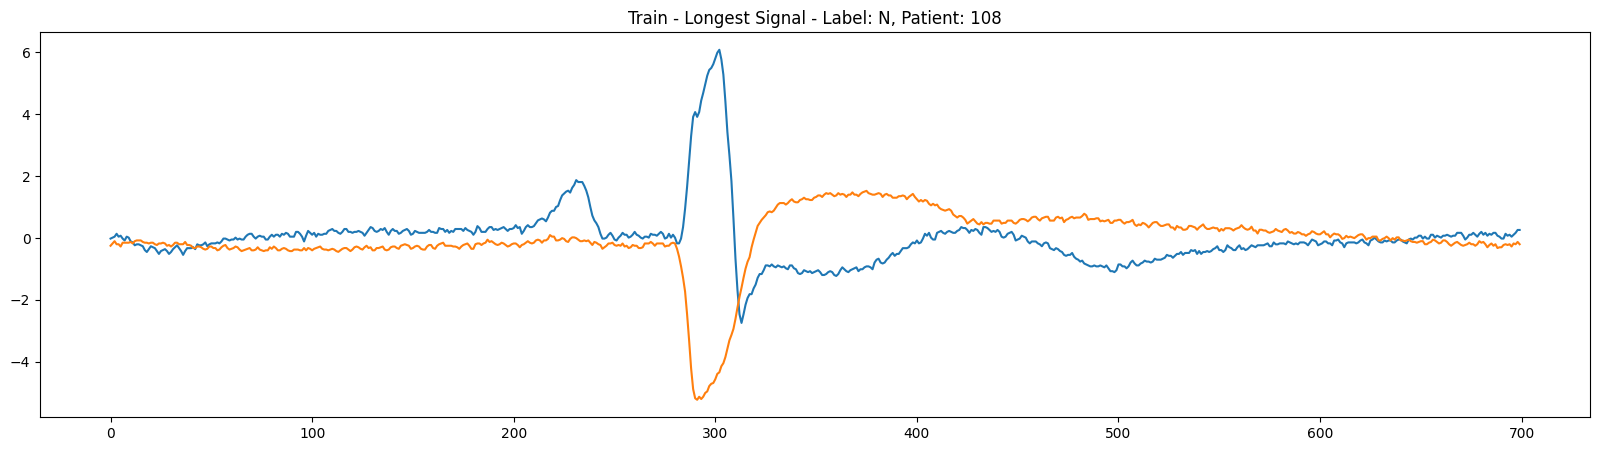

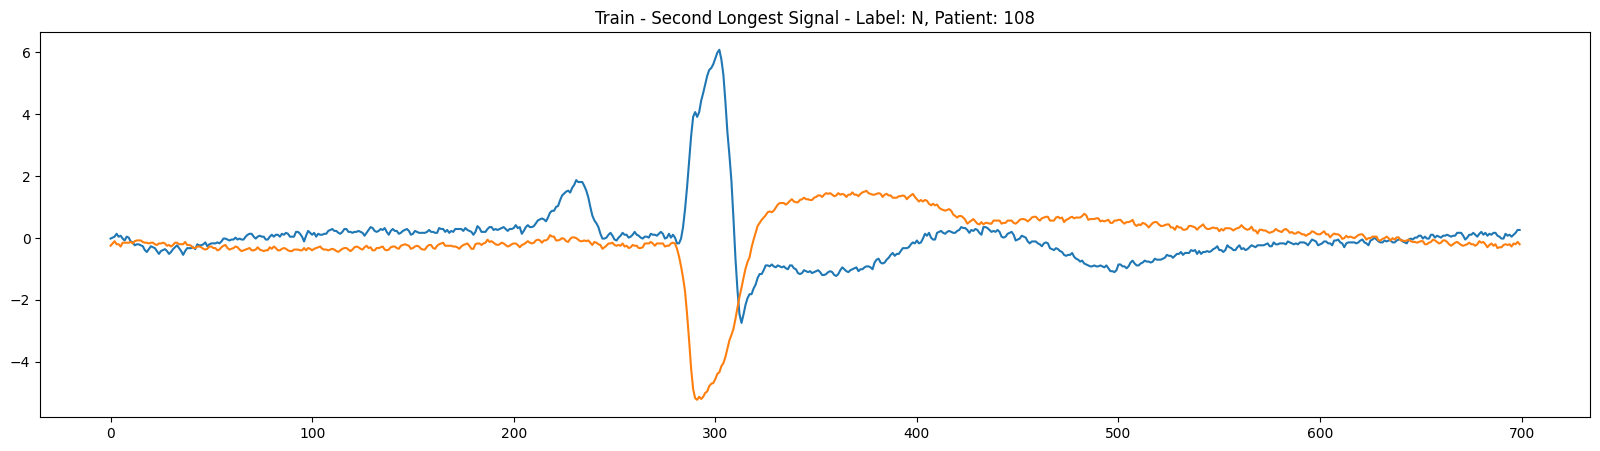

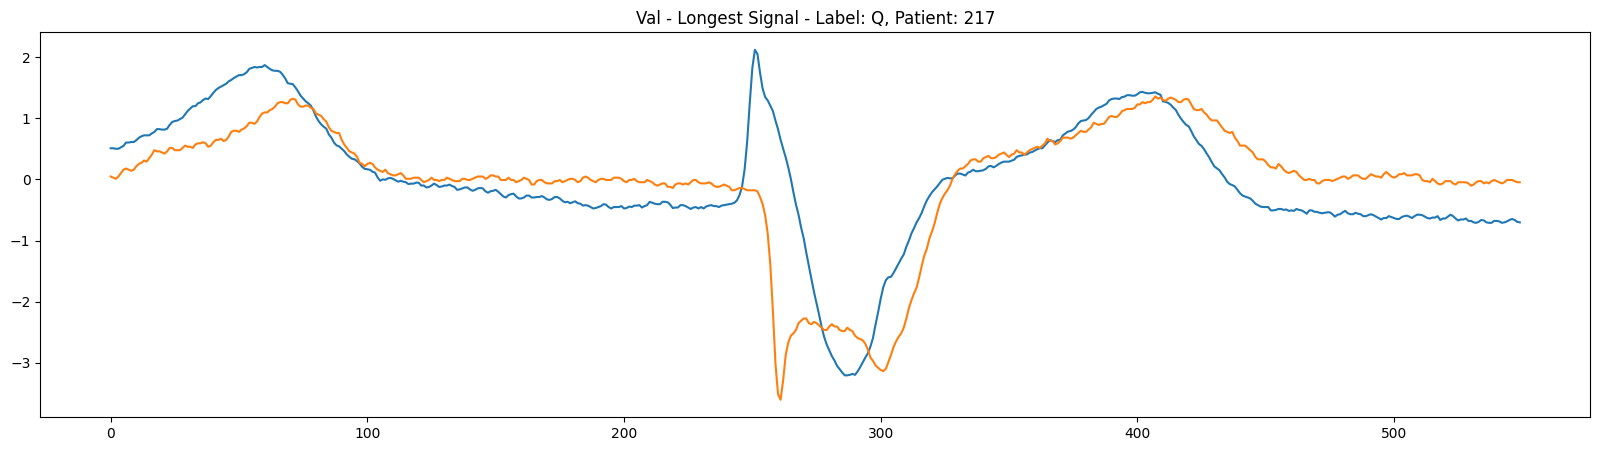

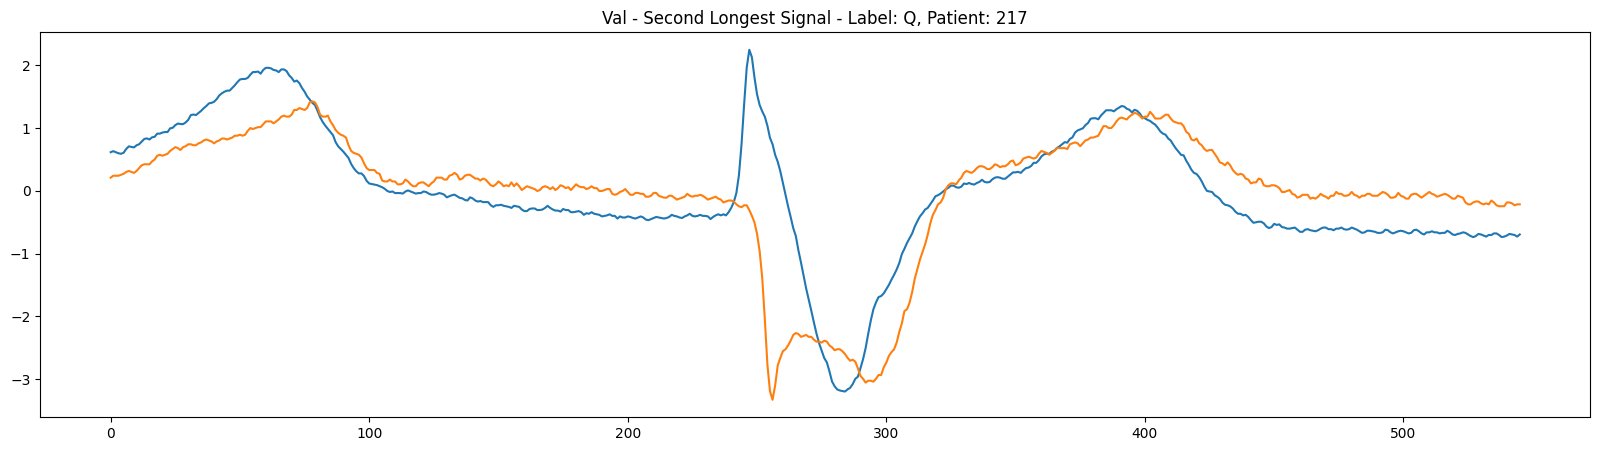

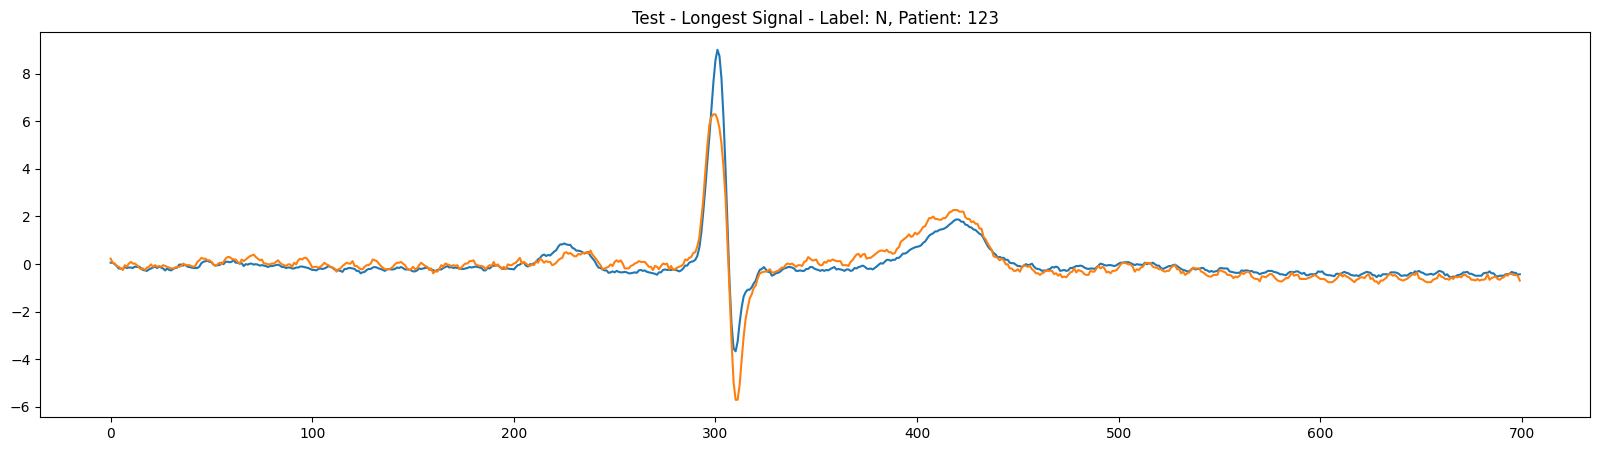

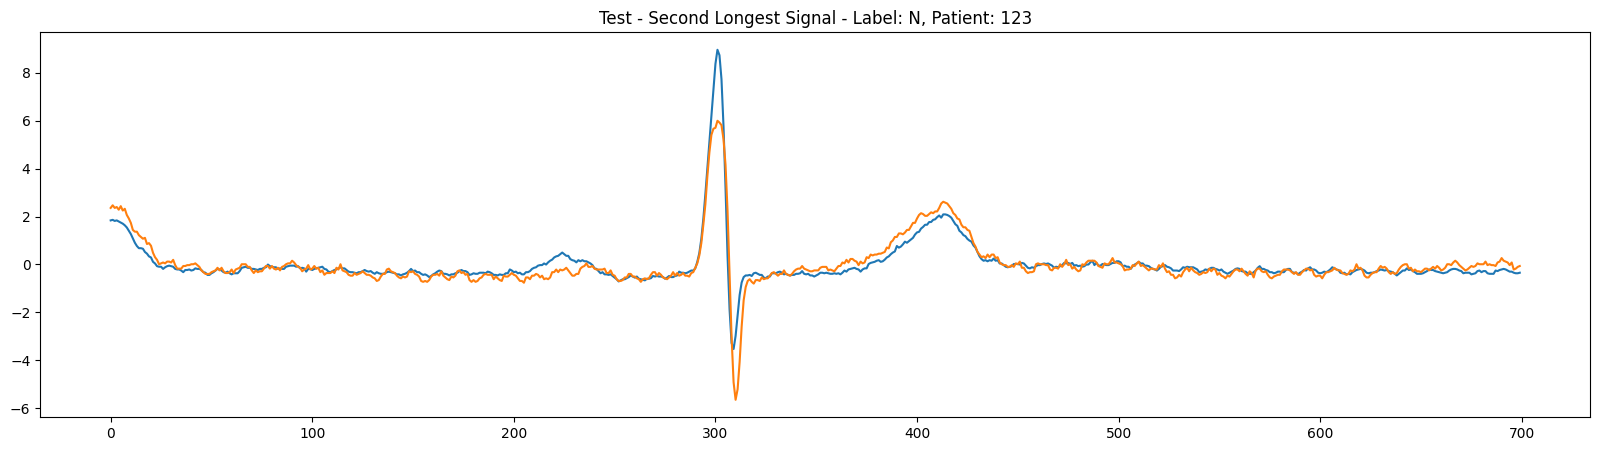

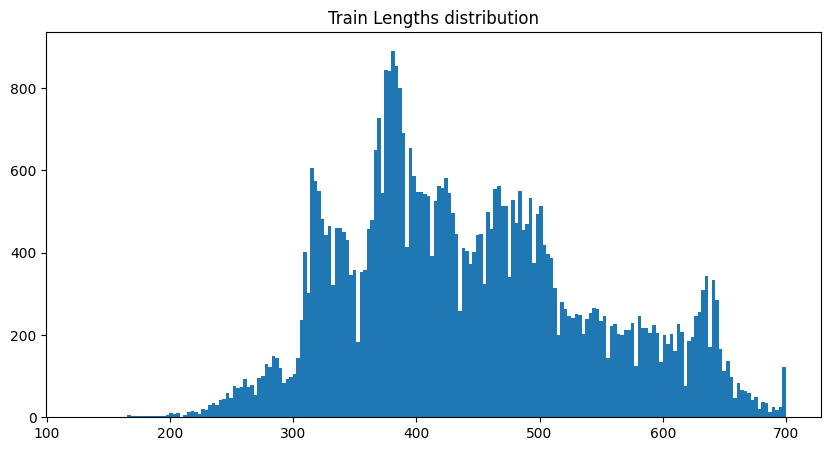

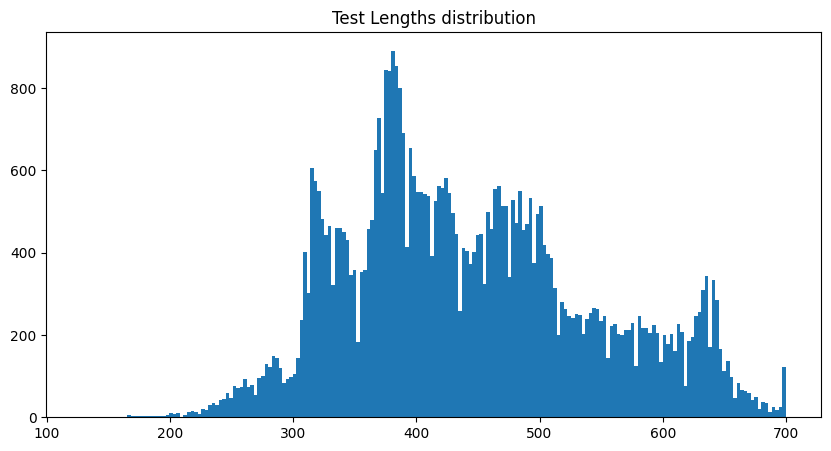

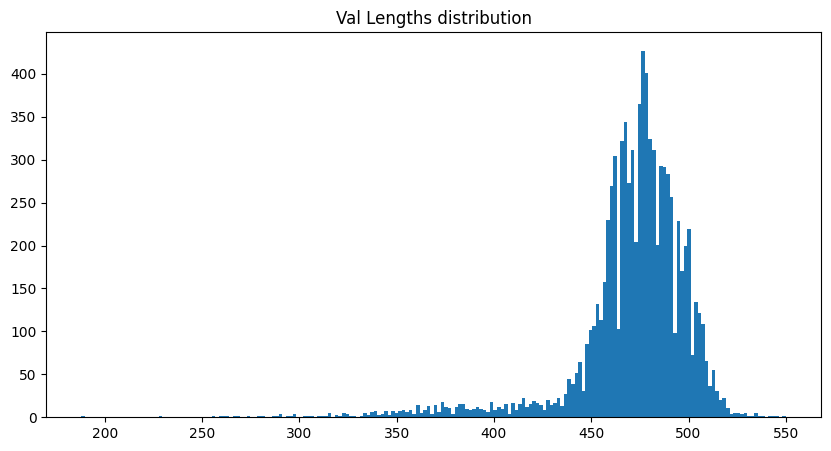

In [8]:
# count the number of samples for each class
from collections import Counter
labels = [label for _, label, _, _ in processed_samples_train]
origs = [orig for _, _, _, orig in processed_samples_train]
print(Counter(labels))
print('len of training smples', len(origs))
print(Counter(origs))

labels = [label for _, label, _, _ in processed_samples_test]
print(Counter(labels))
print('len of test smples', len(labels))

labels = [label for _, label, _, _ in processed_samples_val]
print(Counter(labels))
print('len of val smples', len(labels))

# measure the average length of the samples as well as maximum and minimum
lengths_train = [len(signal) for signal, _, _, _ in processed_samples_train]
print(f'Average length train: {np.mean(lengths_train)}')
print(f'Max length train: {np.max(lengths_train)}')
print(f'Min length train: {np.min(lengths_train)}')

lengths_test = [len(signal) for signal, _, _, _ in processed_samples_test]
print(f'Average length test: {np.mean(lengths_test)}')
print(f'Max length test: {np.max(lengths_test)}')
print(f'Min length test: {np.min(lengths_test)}')

lengths_val = [len(signal) for signal, _ ,_, _ in processed_samples_val]
print(f'Average length val: {np.mean(lengths_val)}')
print(f'Max length val: {np.max(lengths_val)}')
print(f'Min length val: {np.min(lengths_val)}')

# plot the longest signal
import matplotlib.pyplot as plt

# plot the longest signal from train
signal, label, pat_id, _ = processed_samples_train[np.argmax(lengths_train)]
plt.figure(figsize=(20, 5))
plt.plot(signal)
plt.title(f'Train - Longest Signal - Label: {label}, Patient: {pat_id}')

# plot the second longest signal from train
signal, label, pat_id, _ = processed_samples_train[np.argsort(lengths_train)[-2]]
plt.figure(figsize=(20, 5))
plt.plot(signal)
plt.title(f'Train - Second Longest Signal - Label: {label}, Patient: {pat_id}')

# plot the longest signal from val
lengths_val = [len(signal) for signal, _, _, _ in processed_samples_val]
signal, label, pat_id, _ = processed_samples_val[np.argmax(lengths_val)]
plt.figure(figsize=(20, 5))
plt.plot(signal)
plt.title(f'Val - Longest Signal - Label: {label}, Patient: {pat_id}')

# plot the second longest signal from val
signal, label, pat_id, _ = processed_samples_val[np.argsort(lengths_val)[-2]]
plt.figure(figsize=(20, 5))
plt.plot(signal)
plt.title(f'Val - Second Longest Signal - Label: {label}, Patient: {pat_id}')


# plot the longest signal from test
lengths_test = [len(signal) for signal, _, _, _ in processed_samples_test]
signal, label, pat_id, _ = processed_samples_test[np.argmax(lengths_test)]
plt.figure(figsize=(20, 5))
plt.plot(signal)
plt.title(f'Test - Longest Signal - Label: {label}, Patient: {pat_id}')

# plot the second longest signal from test
signal, label, pat_id, _ = processed_samples_test[np.argsort(lengths_test)[-2]]
plt.figure(figsize=(20, 5))
plt.plot(signal)
plt.title(f'Test - Second Longest Signal - Label: {label}, Patient: {pat_id}')
# plot the distribution of the lengths for train
plt.figure(figsize=(10, 5))
plt.hist(lengths_test, bins=200)
plt.title('Train Lengths distribution')

# plot the distribution of the lengths for test
plt.figure(figsize=(10, 5))
plt.hist(lengths_test, bins=200)
plt.title('Test Lengths distribution')

# plot the distribution of the lengths for val
plt.figure(figsize=(10, 5))
plt.hist(lengths_val, bins=200)
plt.title('Val Lengths distribution')

# print the number of samples that has len bigger than 500
print('Samples longer than 800 train: ', len([l for l in lengths_train if l > 800]))
print('Samples longer than 800 test: ', len([l for l in lengths_test if l > 800]))
print('Samples longer than 800 val: ', len([l for l in lengths_val if l > 800]))

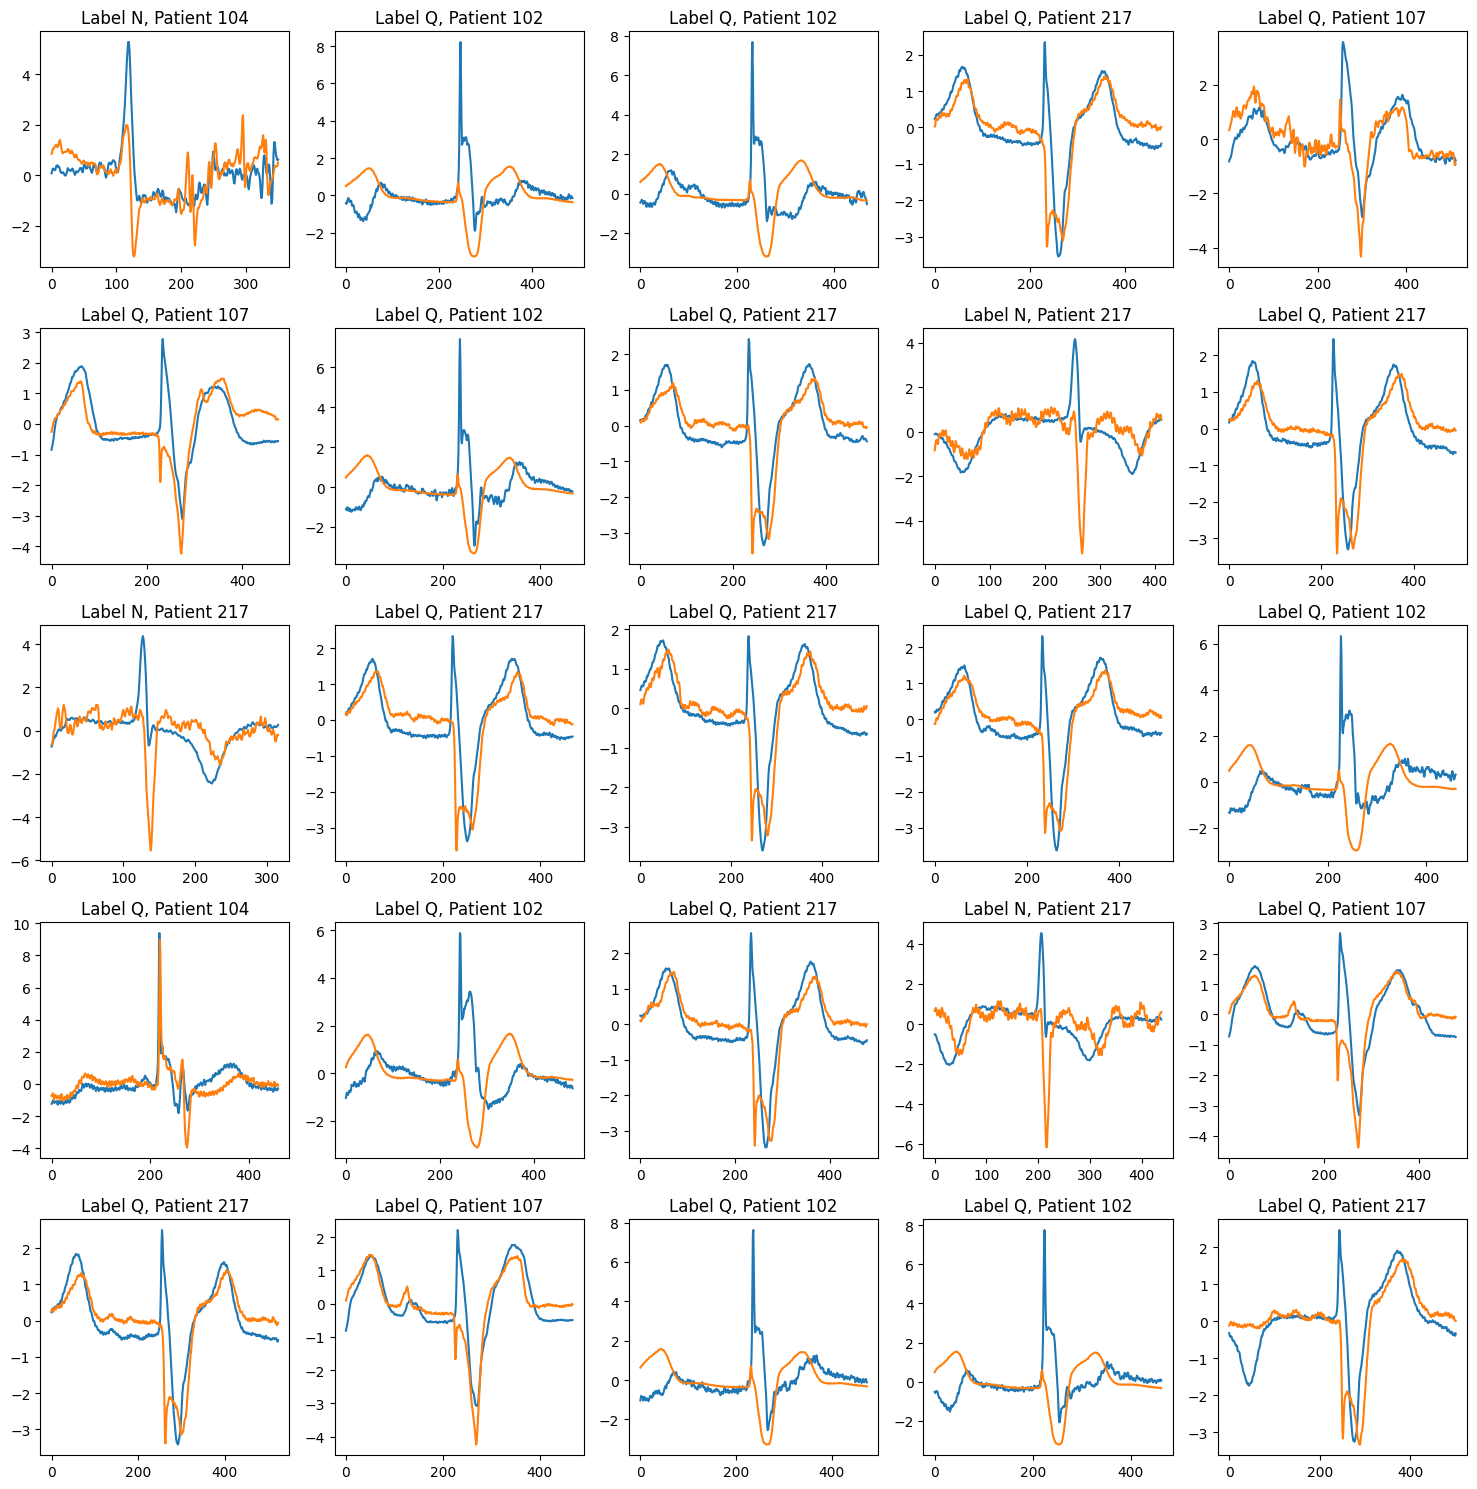

In [9]:
import random

# plot some processed samples in a grid
import matplotlib.pyplot as plt

fig, axes = plt.subplots(5, 5, figsize=(15, 15))
axes = axes.flatten()

random_indices = random.sample(range(len(processed_samples_val)), 25)

for i, idx in enumerate(random_indices):
    signal, label, pat_id, _ = processed_samples_val[idx]
    axes[i].plot(signal)
    axes[i].set_title(f'Label {label}, Patient {pat_id}')
    # axes[i].axis('off')

plt.tight_layout()
plt.show()

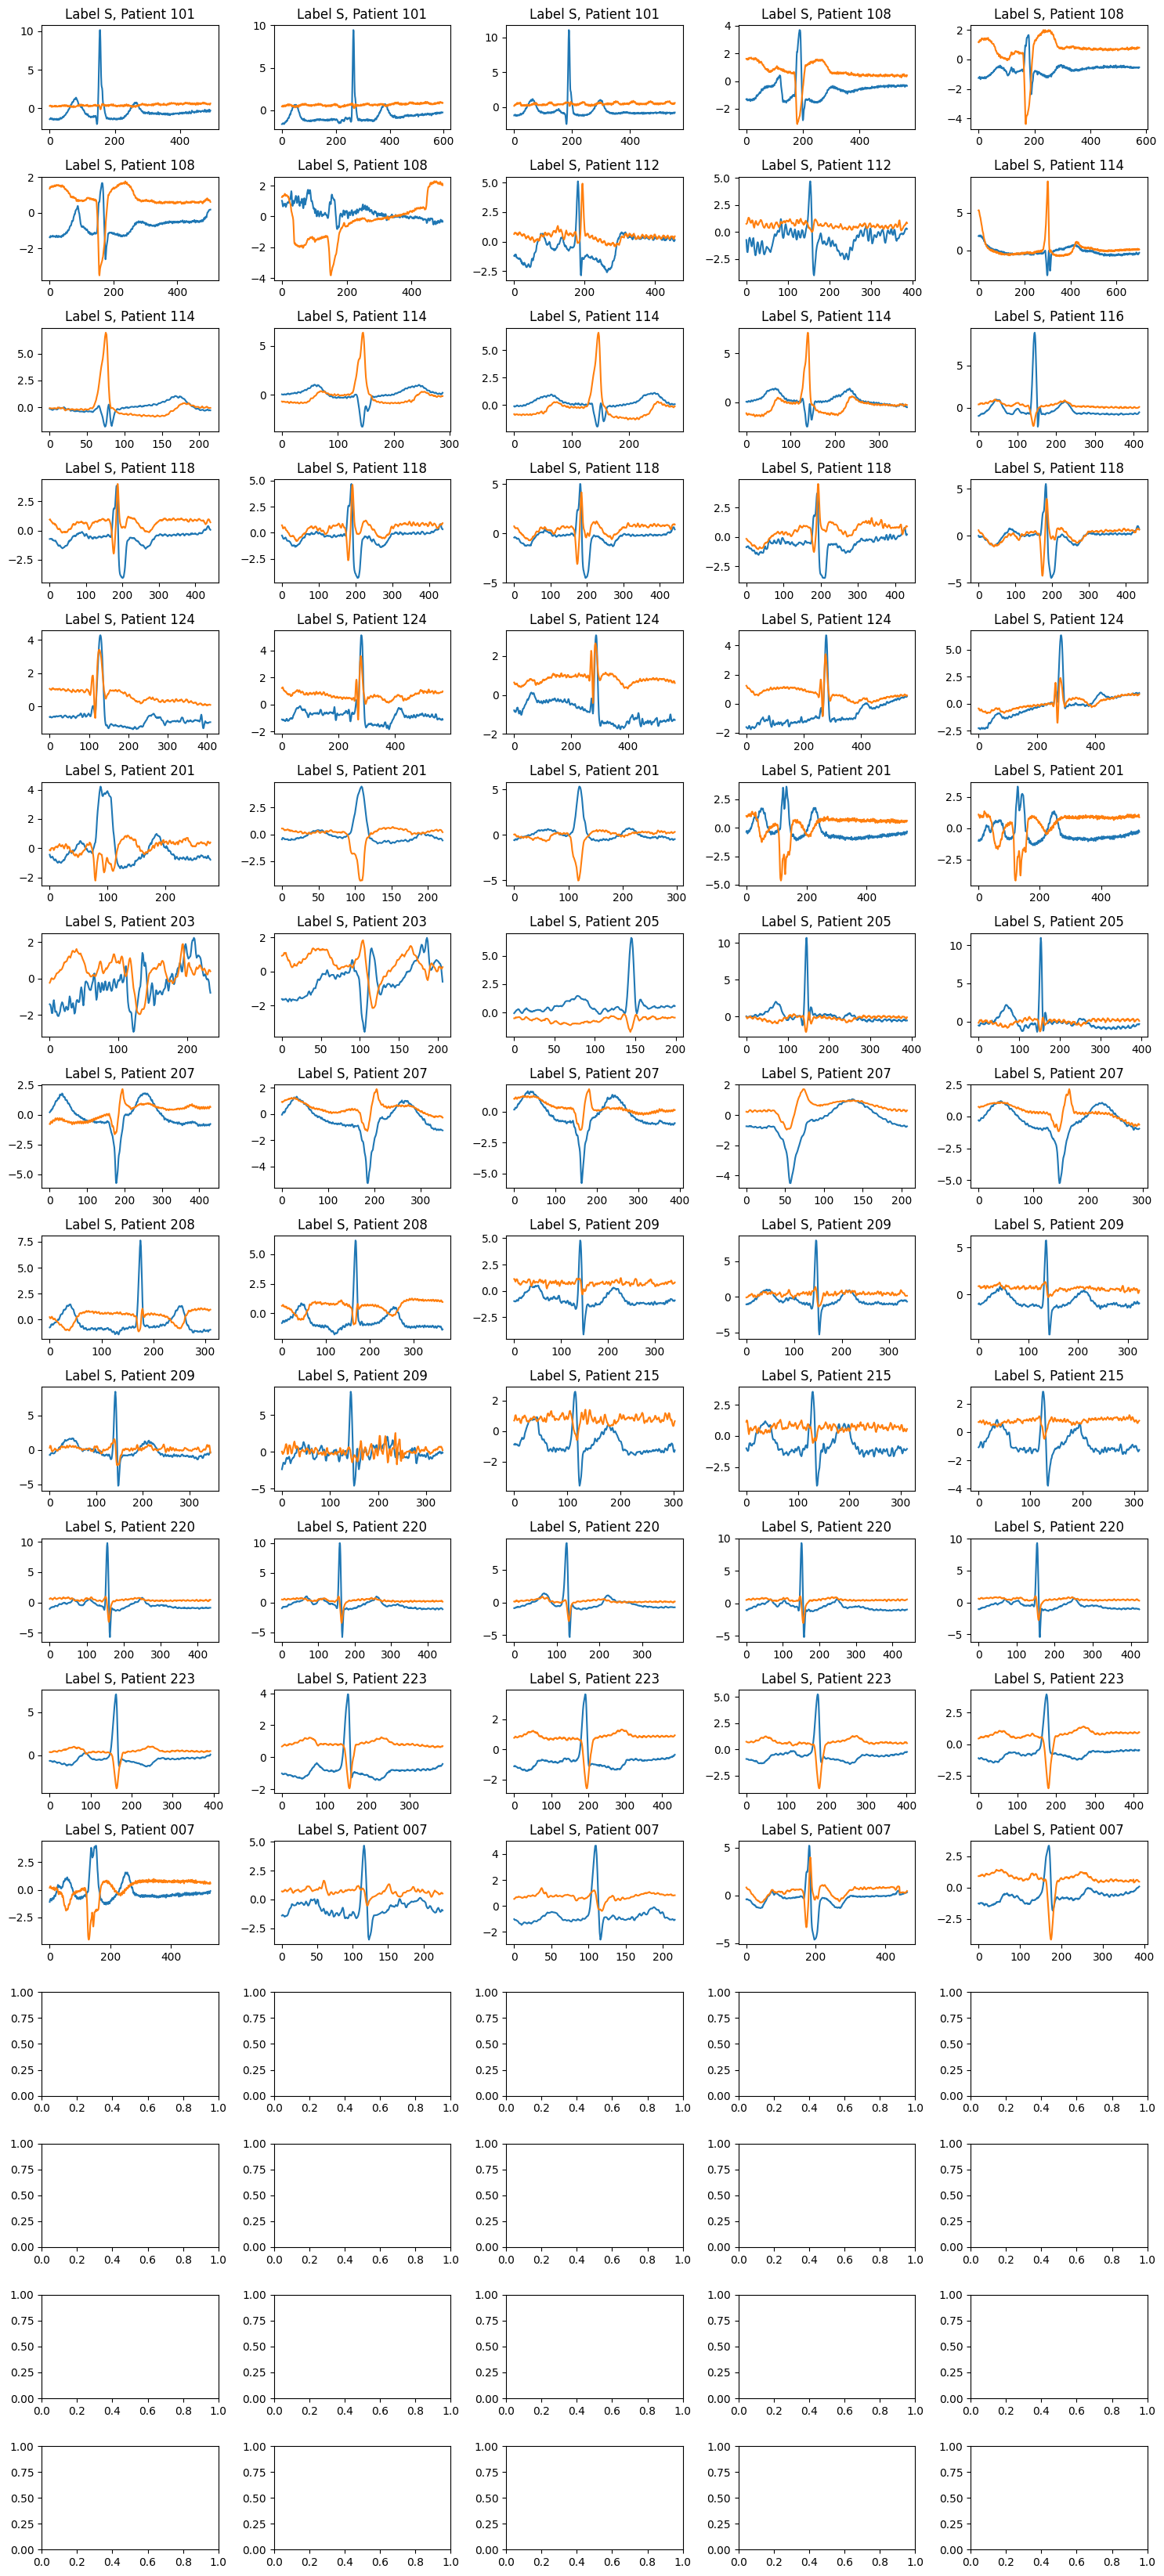

In [ ]:
import random

# plot some processed samples in a grid
import matplotlib.pyplot as plt

fig, axes = plt.subplots(17, 5, figsize=(15, 33))
axes = axes.flatten()

count = 0
pats = {}
for i, (signal, label, pat_id) in enumerate(processed_samples_train):
    if label == 'S' and not (pat_id in pats.keys() and pats[pat_id] > 4):
        if pat_id not in pats.keys():
            pats[pat_id] = 1
        else:
            pats[pat_id] += 1
        axes[count].plot(signal)
        axes[count].set_title(f'Label {label}, Patient {pat_id}')
        count += 1
    if count == 17 * 5: 
        break

    # axes[i].axis('off')

plt.tight_layout()
plt.show()

annotation.symbol len: 3040
annotation.symbol: ['+', 'F', 'V', 'N', 'F', 'V', 'N', 'V', 'V', 'N', 'V', 'V', 'N', 'V', 'V', 'N', 'V', 'V', 'N', 'F', 'V', 'N', 'F', 'V', 'N', 'F', 'V', 'N', 'V', 'V', '~', 'N', 'F', 'V', 'N', 'N', 'F', 'N', 'N', '~', 'N', 'V', 'N', 'N', 'N', 'V', 'N', 'N', 'N', 'V', 'N', 'N', 'N', 'V', 'N', 'N', 'N', 'V', 'N', 'N', 'N', 'V', 'N', 'N', 'N', 'N', '~', 'N', 'F', 'N', 'N', 'N', 'N', 'N', 'N', 'V', 'N', 'N', 'V', 'N', 'N', 'F', 'N', 'N', 'V', 'N', 'N', 'V', 'N', 'N', 'F', 'N', 'N', 'N', 'N', 'N', 'N', 'V', 'N', 'N', 'V', '~', 'N', 'N', 'F', 'V', 'N', 'F', 'V', 'N', 'N', 'V', 'N', 'N', 'F', '+', 'V', 'N', 'N', 'V', 'N', 'N', 'V', 'N', 'N', 'V', 'V', 'N', 'F', 'V', 'N', 'F', 'V', 'N', 'N', 'V', 'N', 'N', 'V', '+', 'N', 'N', 'V', 'V', 'N', 'V', 'V', 'N', 'F', 'V', 'N', 'N', 'N', 'N', 'N', 'V', 'V', 'N', 'V', 'V', 'N', 'F', 'V', 'N', 'N', 'F', 'N', 'N', 'N', 'N', 'N', 'F', 'V', 'N', 'F', '+', 'V', 'N', 'N', 'V', 'N', 'N', 'V', '+', 'N', 'N', 'F', 'V', 'N', 'N', 'N

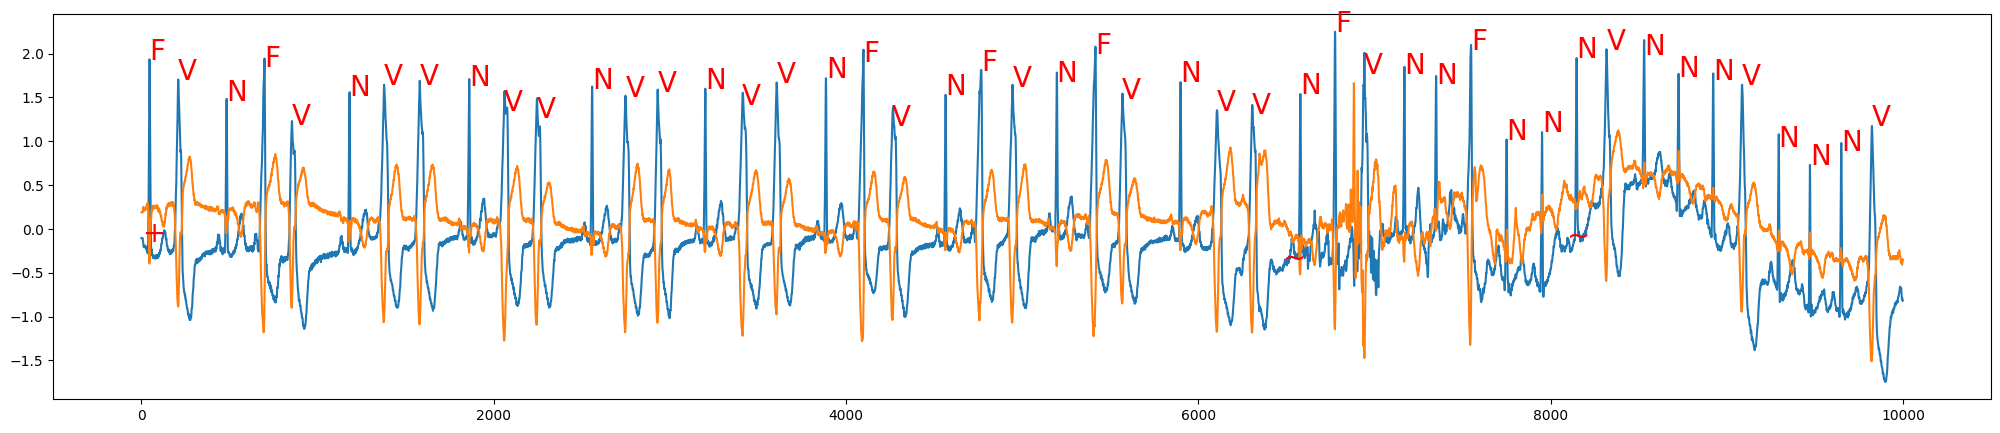

In [ ]:
import neurokit2 as nk

patient = 208
annotation = wfdb.rdann(f'/media/luna97/MIT-BHI/data/raw/{patient}', 'atr')
print(f'annotation.symbol len: {len(annotation.symbol)}')
print(f'annotation.symbol: {annotation.symbol}')
print(f'annotation.sample len: {len(annotation.sample)}')
print(f'annotation.sample: {annotation.sample}')

signal, _ = wfdb.rdsamp(f'/media/luna97/MIT-BHI/data/raw/{patient}')
print(f'signal len: {len(signal)}')
print(f'signal shape: {signal.shape}')

min_idx = 0
max_idx = 10000

r_peaks = [s for s in annotation.sample if s < max_idx and s > min_idx]
print(f'r_peaks: {r_peaks}')

# signals, waves = nk.ecg_delineate(signal[min_idx:max_idx, 0], r_peaks, show=False, sampling_rate=360)

#nk.events_plot([waves["ECG_P_Offsets"]], signal[:2000, 0])
#print(f'waves: {waves.keys()}')

import matplotlib.pyplot as plt

# Plot the signal
plt.figure(figsize=(25, 5))
plt.plot(range(min_idx, max_idx), signal[min_idx:max_idx])
# print(f'signal[{min_idx}:{max_idx}, 0]: {signal[min_idx:max_idx,]}')

# Plot the annotation symbols
for symbol, sample in zip(annotation.symbol, annotation.sample):
    if sample < max_idx and sample > min_idx:  # Only plot symbols within the first 1000 samples
        # print(f'{sample}: {symbol}')
        plt.text(sample, signal[sample, 0], symbol, color='red', fontsize=20)

plt.show()

array([<Axes: >, <Axes: >, <Axes: >], dtype=object)

<Figure size 2500x500 with 0 Axes>

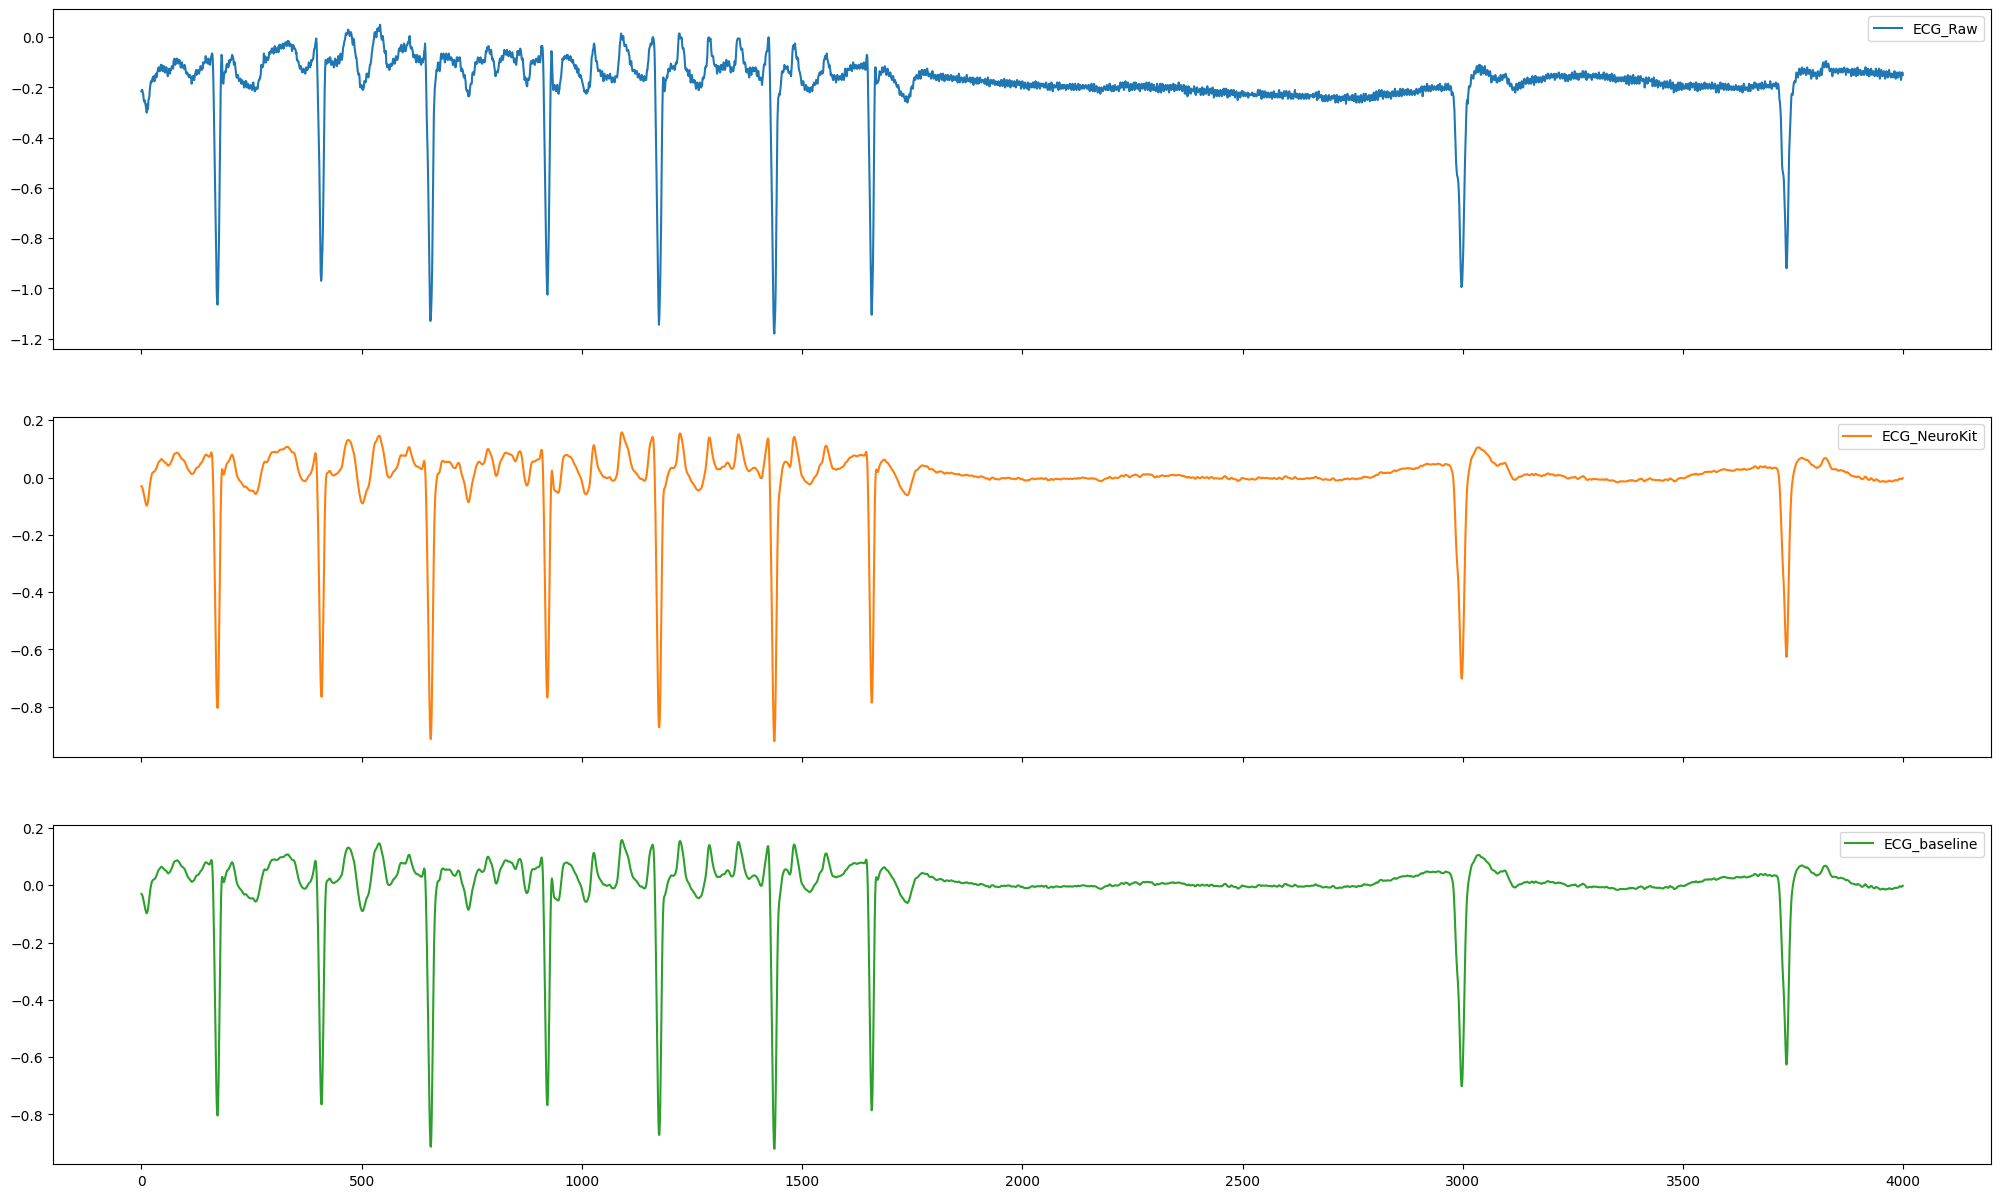

In [ ]:
import matplotlib.pyplot as plt
from pandas import DataFrame

# Plot the signal
plt.figure(figsize=(25, 5))

ecg = signal[min_idx:max_idx, 1]

# remove baseline wander

signals = DataFrame({
    "ECG_Raw" : ecg,
    "ECG_NeuroKit" : nk.ecg_clean(ecg, sampling_rate=250, method="neurokit"),
    "ECG_baseline" : nk.ecg_clean(ecg, sampling_rate=250, method="nk"),
})

signals.plot(subplots=True, figsize=(25, 15))



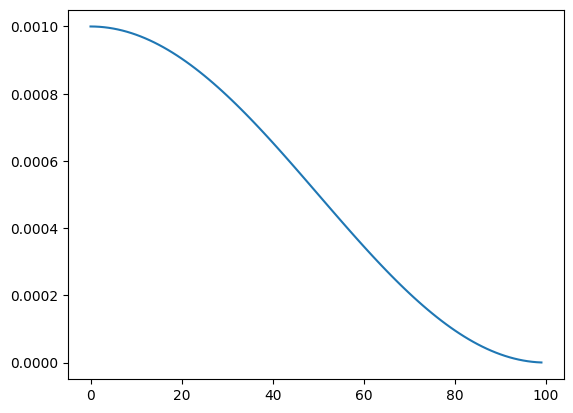

In [ ]:
# simulate lr cosine alnnealing
import torch
import torch.optim as optim
import matplotlib.pyplot as plt

optimizer = torch.optim.Adam([torch.tensor([1.0])])
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=100)  # T_max is the number of iterations for the first half of the cycle

lrs = []
for i in range(100):
    optimizer.step()
    lrs.append(optimizer.param_groups[0]['lr'])
    scheduler.step()

plt.plot(lrs)
